In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure as fig
from pylab import rcParams
import datetime
from datetime import timedelta
import statsmodels.api as sm
rcParams['figure.figsize'] = 20,10
from ResearchClass import PlotEvaluations, EvaluationMetrics, TradesBook, StrategyTemplate
import os

pd.options.mode.chained_assignment = None  # default='warn'


        Assets:		 ['data/MNQc1.parquet']
        Start date:	 2024-11-27 00:00:00
        End date:	 2025-01-25 00:00:00
        Frequency: 	 2m
        ---------------------------
        trade_df:		 308
        Costs: 		 $985.6/month
        Sharpe:		 -2.12 
        Sortino:	 -1.909 
        t-stat:		 -4.803
        Total return: 	 92.65%
        Win rate:	 23.05%
        Avg trade:	 -0.025%
        Avg win:	 0.011% 
        Avg loss:	 -0.035%
        Min trade size:	 $-3983268
        Avg trade time:	 2512.961038961039
        Avg win time:	 39.2112676056338
        Avg loss time:	 3254.0421940928272
        


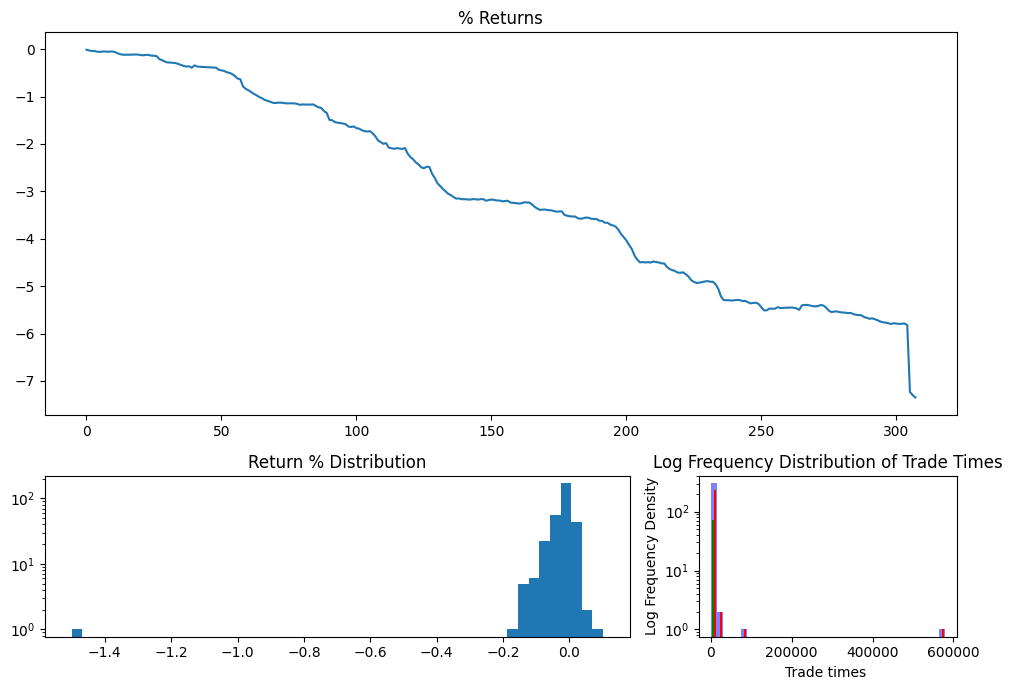

In [7]:
class AMCrossover(StrategyTemplate):
    """
    AMCrossover strategy class that inherits from StrategyTemplate.
    This strategy uses a simple moving average (SMA) crossover to generate buy and sell signals.
    """

    def AddIndicators(self):
        """
        Adds the necessary indicators to the data.
        Specifically, it calculates the short and long period SMAs.
        """
        SHORT_LOOKBACK_PERIOD = self.indicator_parameters[0]
        LONG_LOOKBACK_PERIOD = self.indicator_parameters[1]
        self.data['SMA_SHORT'] = self.data['Close'].rolling(SHORT_LOOKBACK_PERIOD).mean()
        self.data['SMA_LONG'] = self.data['Close'].rolling(LONG_LOOKBACK_PERIOD).mean()

    def strategyLogic(self, TradeBook, row, idx):
        """
        Defines the strategy logic for the AMCrossover strategy.

        Parameters:
        - TradeBook: The TradeBook object that manages trades.
        - row: The current row of data.
        - idx: The current index in the data.
        """
        # Skip the initial periods to allow for indicator warmup
        if idx < self.indicator_parameters[1]:
            return

        # Close trade if an active order execution price is met
        if TradeBook.CurrentSizing() != 0 and TradeBook.ActiveOrderExecutionPrice(row):
            TradeBook.CloseTrade(TradeBook.ActiveOrderExecutionPrice(row), idx)

        # Open a long trade if the short SMA crosses above the long SMA
        if TradeBook.CurrentSizing() == 0 and self.data['SMA_SHORT'][idx-1] > self.data['SMA_LONG'][idx-1]:
            entry = row['Open']
            stop = row['Open'] * (1 - self.indicator_parameters[2])
            target = row['SMA_LONG']
            TradeBook.OpenTrade(entry, 1, stop, idx, target)

        # Open a short trade if the short SMA crosses below the long SMA
        if TradeBook.CurrentSizing() == 0 and self.data['SMA_SHORT'][idx-1] < self.data['SMA_LONG'][idx-1]:
            entry = row['Open']
            stop = row['Open'] * (1 + self.indicator_parameters[2])
            target = row['SMA_LONG']
            TradeBook.OpenTrade(entry, -1, stop, idx, target)

# Parameters: [short lookback period, long lookback period, stop loss percentage]
parameters = [5, 20, 0.015]
ticker_list = ['data/MNQc1.parquet']
today = datetime.datetime.now()
start_date = str((today - datetime.timedelta(days=59)).strftime("%Y-%m-%d"))
end_date = str(today.strftime("%Y-%m-%d"))
interval = "2m"

# Apply the AMCrossover strategy to the specified tickers and date range
AMCROSSOVER_TRADE_BOOK = AMCrossover(ticker_list, start_date, end_date, interval, parameters).ApplyStrategyThroughTickers()

# Evaluate the strategy performance
metrics = EvaluationMetrics(AMCROSSOVER_TRADE_BOOK, ticker_list, start_date, end_date)
plots = PlotEvaluations(AMCROSSOVER_TRADE_BOOK, (10, 7))

# Print the evaluation metrics and plot the summary
metrics.print_results()
plots.PlotSummary()